<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/kidney_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, JitTrace_ELBO
from pyro.optim import Adam
import pandas as pd
import numpy as np
import torch
from pyro.distributions import Gamma
from pyro.distributions import Poisson
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pyro.enable_validation()

# alternative approach
import pystan
import arviz as az
import stan_utility


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('gd80to84.txt', sep='\t', usecols=['state', 'county', 'pop', 'dc'])
datacnt = pd.read_csv('gd85to89.txt', sep='\t', usecols=['county', 'pop', 'dc'])
data['dc'] += datacnt['dc']
data = data.dropna(thresh=1)
population = torch.from_numpy(data['pop'].to_numpy().astype('float32'))
deathcount = torch.from_numpy(data['dc'].to_numpy().astype('float32'))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [3]:
data.head()

,state,county,dc,pop
0,ALABAMA,AUTAUGA,3.0,61921.0
1,ALABAMA,BALDWIN,22.0,170945.0
2,ALABAMA,BARBOUR,1.0,33316.0
3,ALABAMA,BIBB,1.0,30152.0
4,ALABAMA,BLOUNT,8.0,88342.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:347: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


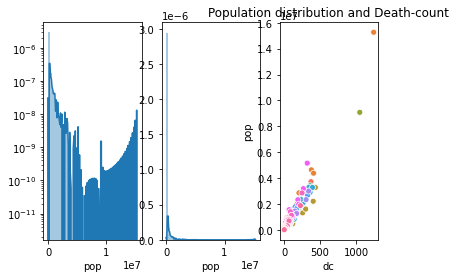

In [4]:
fig, axs = plt.subplots(ncols=3)
axs[0].set(yscale="log")
sns.distplot(data["pop"], ax=axs[0])
sns.distplot(data["pop"], ax=axs[1])
sns.scatterplot(x="dc", y="pop", hue="state", data=data, ax=axs[2], legend=False)
plt.title("Population distribution and Death-count")
plt.show()

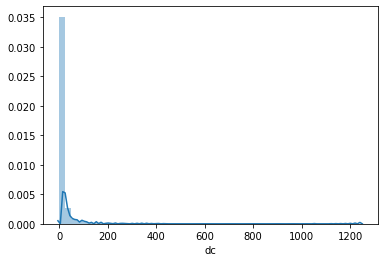

In [5]:
sns.distplot(data["dc"])

**STAN Model**

In [6]:
kidney_cancer_code="""
data {
   int N; // total observations
   int y[N]; // observed deathcount
   vector[N] n; // population
}

parameters {
   vector<lower=0,upper=1>[N] theta; // deathrate estimate
}

transformed parameters {
   vector[N] rate=n .* theta;
}

model {
   theta ~ gamma(20,430000);
   y ~ poisson(rate);
}
"""

In [7]:
dc = data["dc"].to_numpy().astype(int)
pop = data['pop'].to_numpy().astype(int)
deathcount

tensor([ 3., 22.,  1.,  ...,  2.,  2.,  1.])

In [8]:
N = 10
kidney_cancer_dat = {'N': N,
                    'y': dc[0:N],
                    'n': pop[0:N]}

In [9]:
sm = pystan.StanModel(model_code=kidney_cancer_code)
fit = sm.sampling(data=kidney_cancer_dat, iter=5000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f506b6a535fc19fa396bbdd0becb2a9 NOW.


In [10]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 10000 iterations ended with a divergence (0.0%)
0 of 10000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [11]:
la = fit.extract(permuted=True)
theta_result = la['theta']

print(theta_result)

[[4.41258425e-05 8.10544608e-05 4.11453699e-05 ... 5.70815284e-05
  7.59970028e-05 3.17133393e-05]
 [4.56518285e-05 6.65332875e-05 3.31851998e-05 ... 6.19606657e-05
  5.04523892e-05 3.79268727e-05]
 [3.70405723e-05 6.14934801e-05 4.43279594e-05 ... 6.21595866e-05
  5.08031417e-05 5.77498707e-05]
 ...
 [5.51860745e-05 8.20179287e-05 3.80493913e-05 ... 8.59240105e-05
  4.52748378e-05 3.00912341e-05]
 [4.57266340e-05 5.10808190e-05 4.34424740e-05 ... 5.31487551e-05
  4.39611496e-05 5.26447529e-05]
 [3.93435141e-05 6.86301562e-05 5.78754072e-05 ... 4.93252576e-05
  6.47301805e-05 4.72947024e-05]]


In [12]:
la

OrderedDict([('theta',
              array([[4.41258425e-05, 8.10544608e-05, 4.11453699e-05, ...,
                      5.70815284e-05, 7.59970028e-05, 3.17133393e-05],
                     [4.56518285e-05, 6.65332875e-05, 3.31851998e-05, ...,
                      6.19606657e-05, 5.04523892e-05, 3.79268727e-05],
                     [3.70405723e-05, 6.14934801e-05, 4.43279594e-05, ...,
                      6.21595866e-05, 5.08031417e-05, 5.77498707e-05],
                     ...,
                     [5.51860745e-05, 8.20179287e-05, 3.80493913e-05, ...,
                      8.59240105e-05, 4.52748378e-05, 3.00912341e-05],
                     [4.57266340e-05, 5.10808190e-05, 4.34424740e-05, ...,
                      5.31487551e-05, 4.39611496e-05, 5.26447529e-05],
                     [3.93435141e-05, 6.86301562e-05, 5.78754072e-05, ...,
                      4.93252576e-05, 6.47301805e-05, 4.72947024e-05]])),
             ('rate',
              array([[ 2.7323163 , 13.85585481,  1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1485f7acf8>,
      dtype=object)

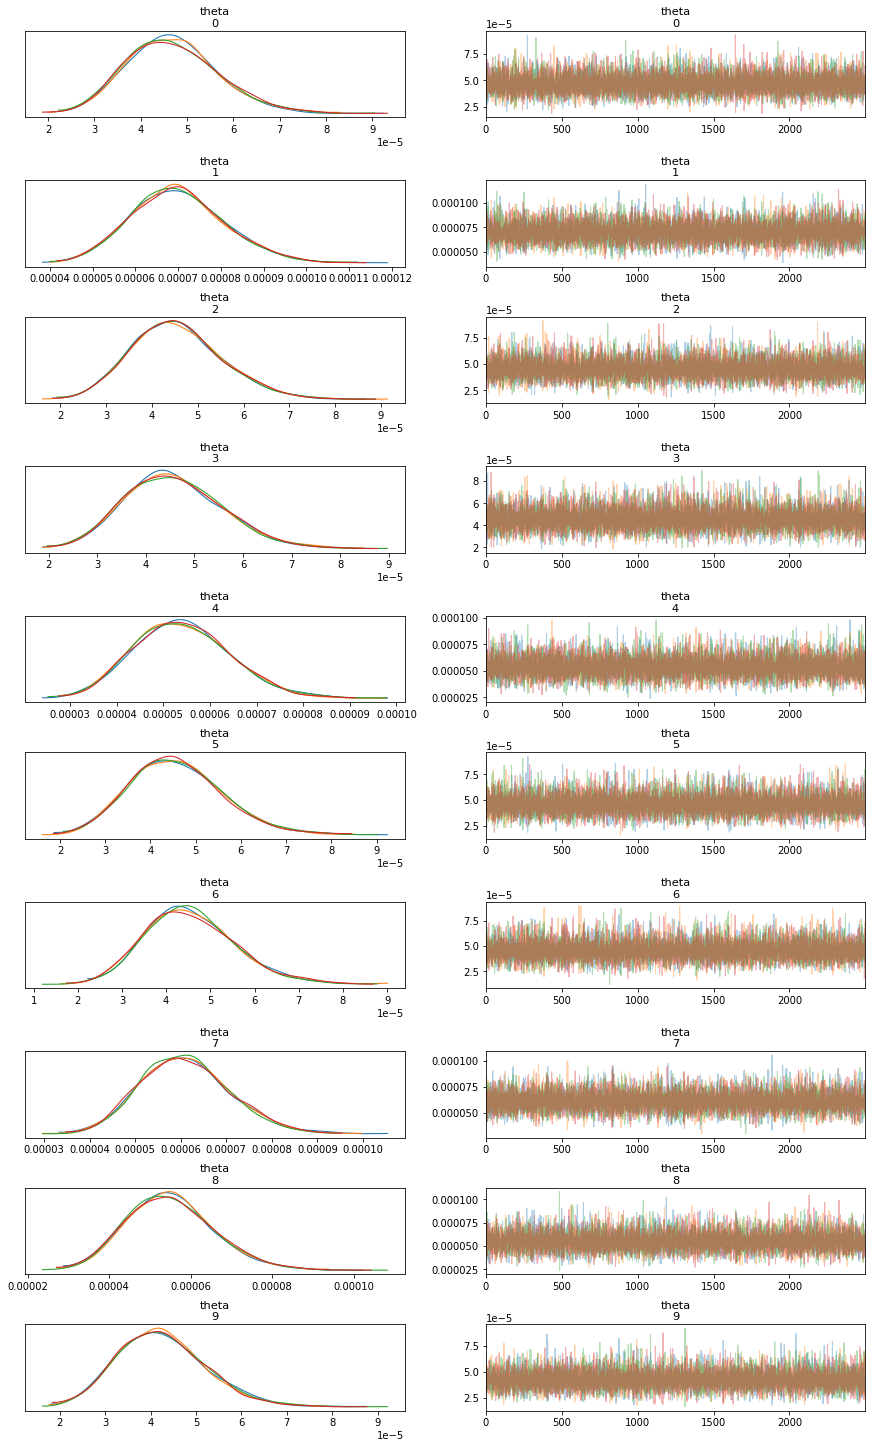

In [13]:
az.plot_trace(fit,var_names=['theta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14818634e0>,
      dtype=object)

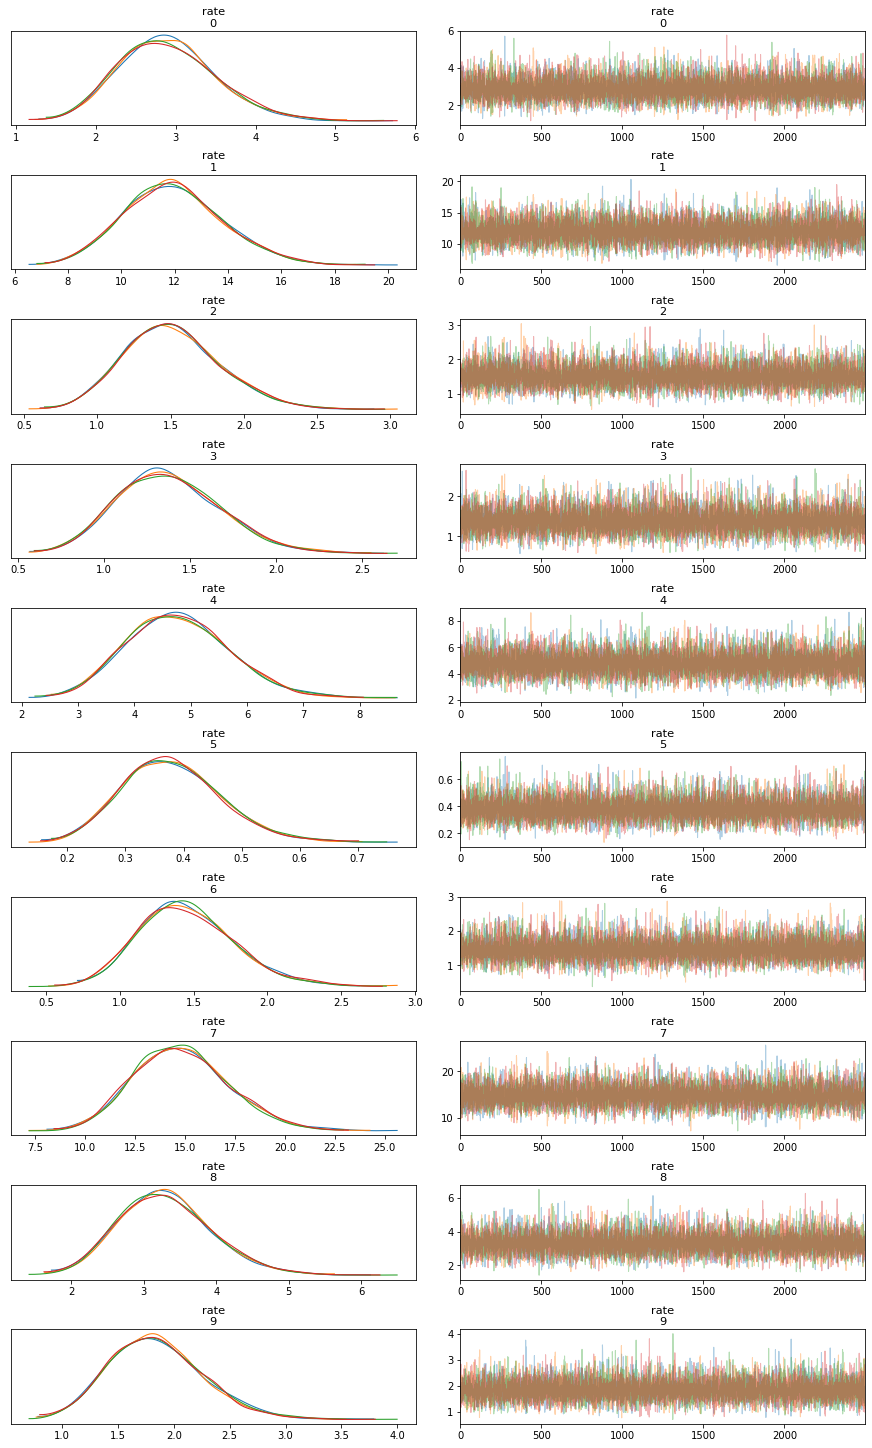

In [14]:
az.plot_trace(fit,var_names=['rate'])

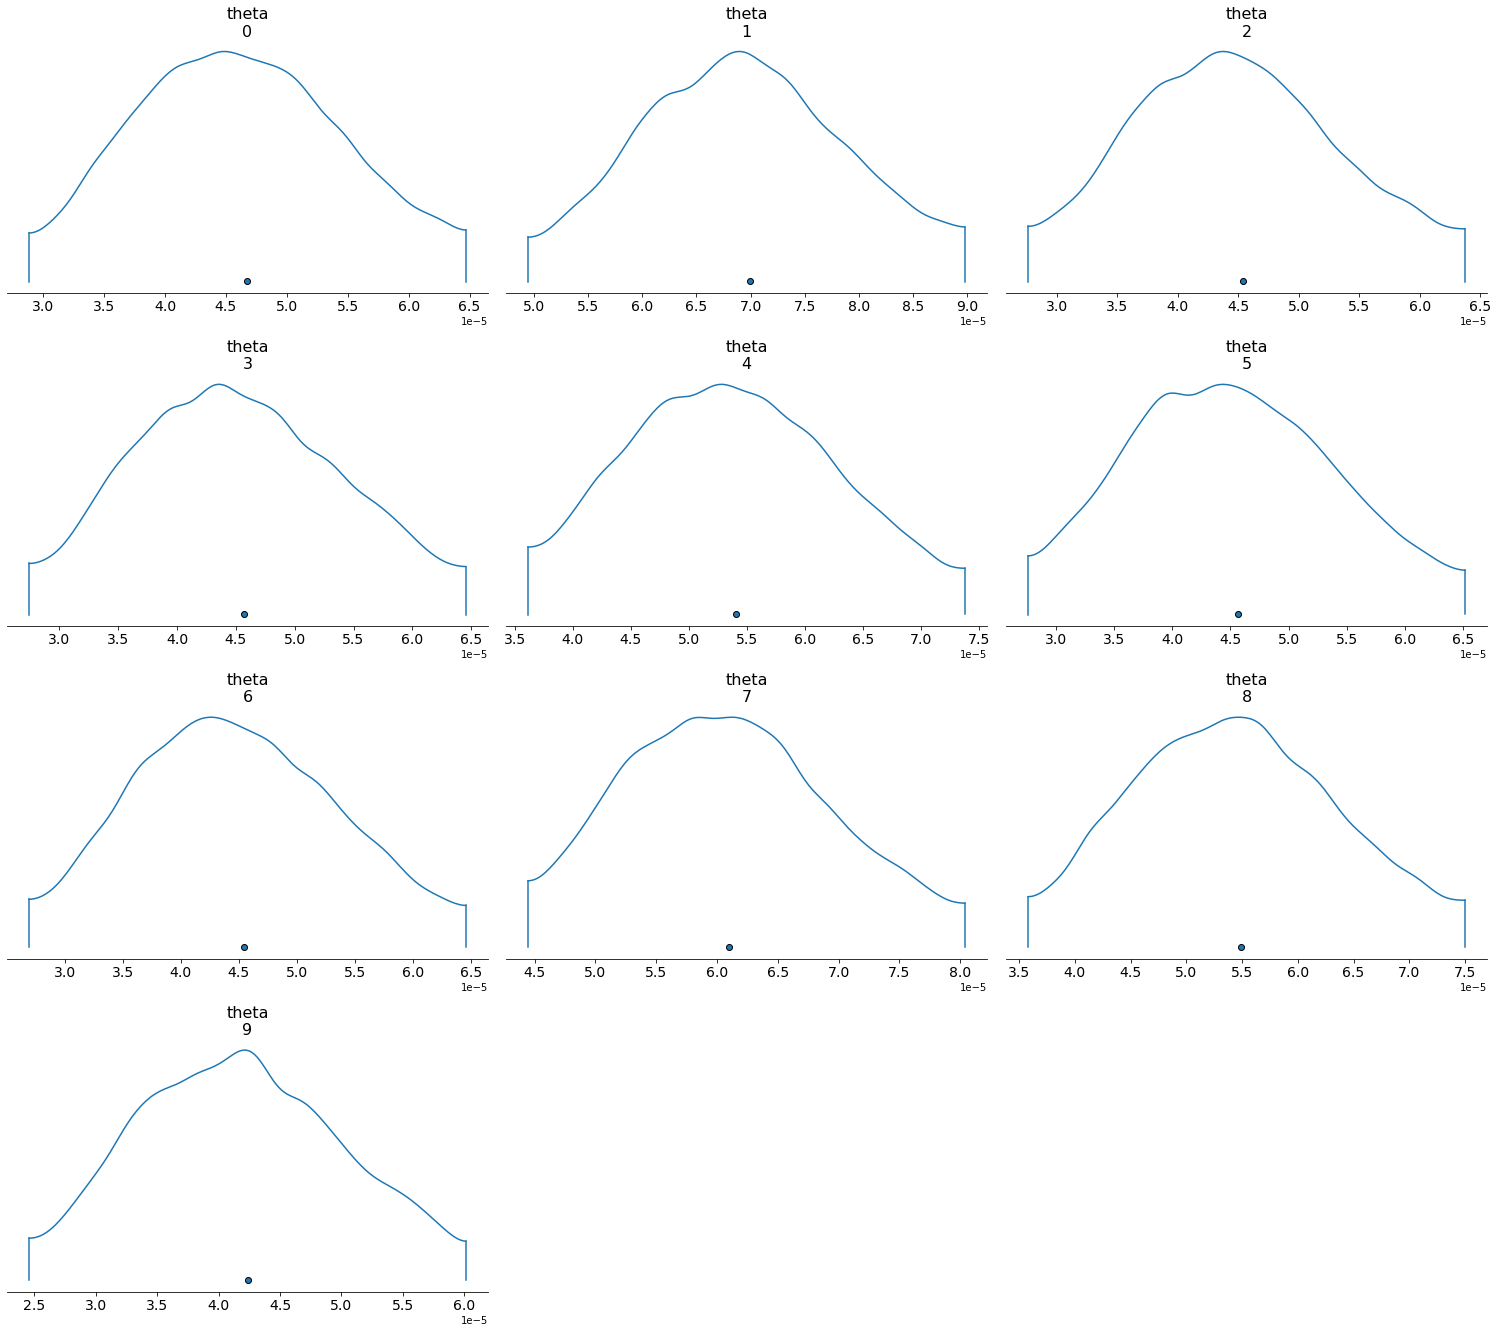

In [15]:
az.plot_density(fit, var_names=["theta"]);

In [16]:
pystan_data = az.from_pystan(
    posterior=fit,
    observed_data=['y'])

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1480588a58>,
      dtype=object)

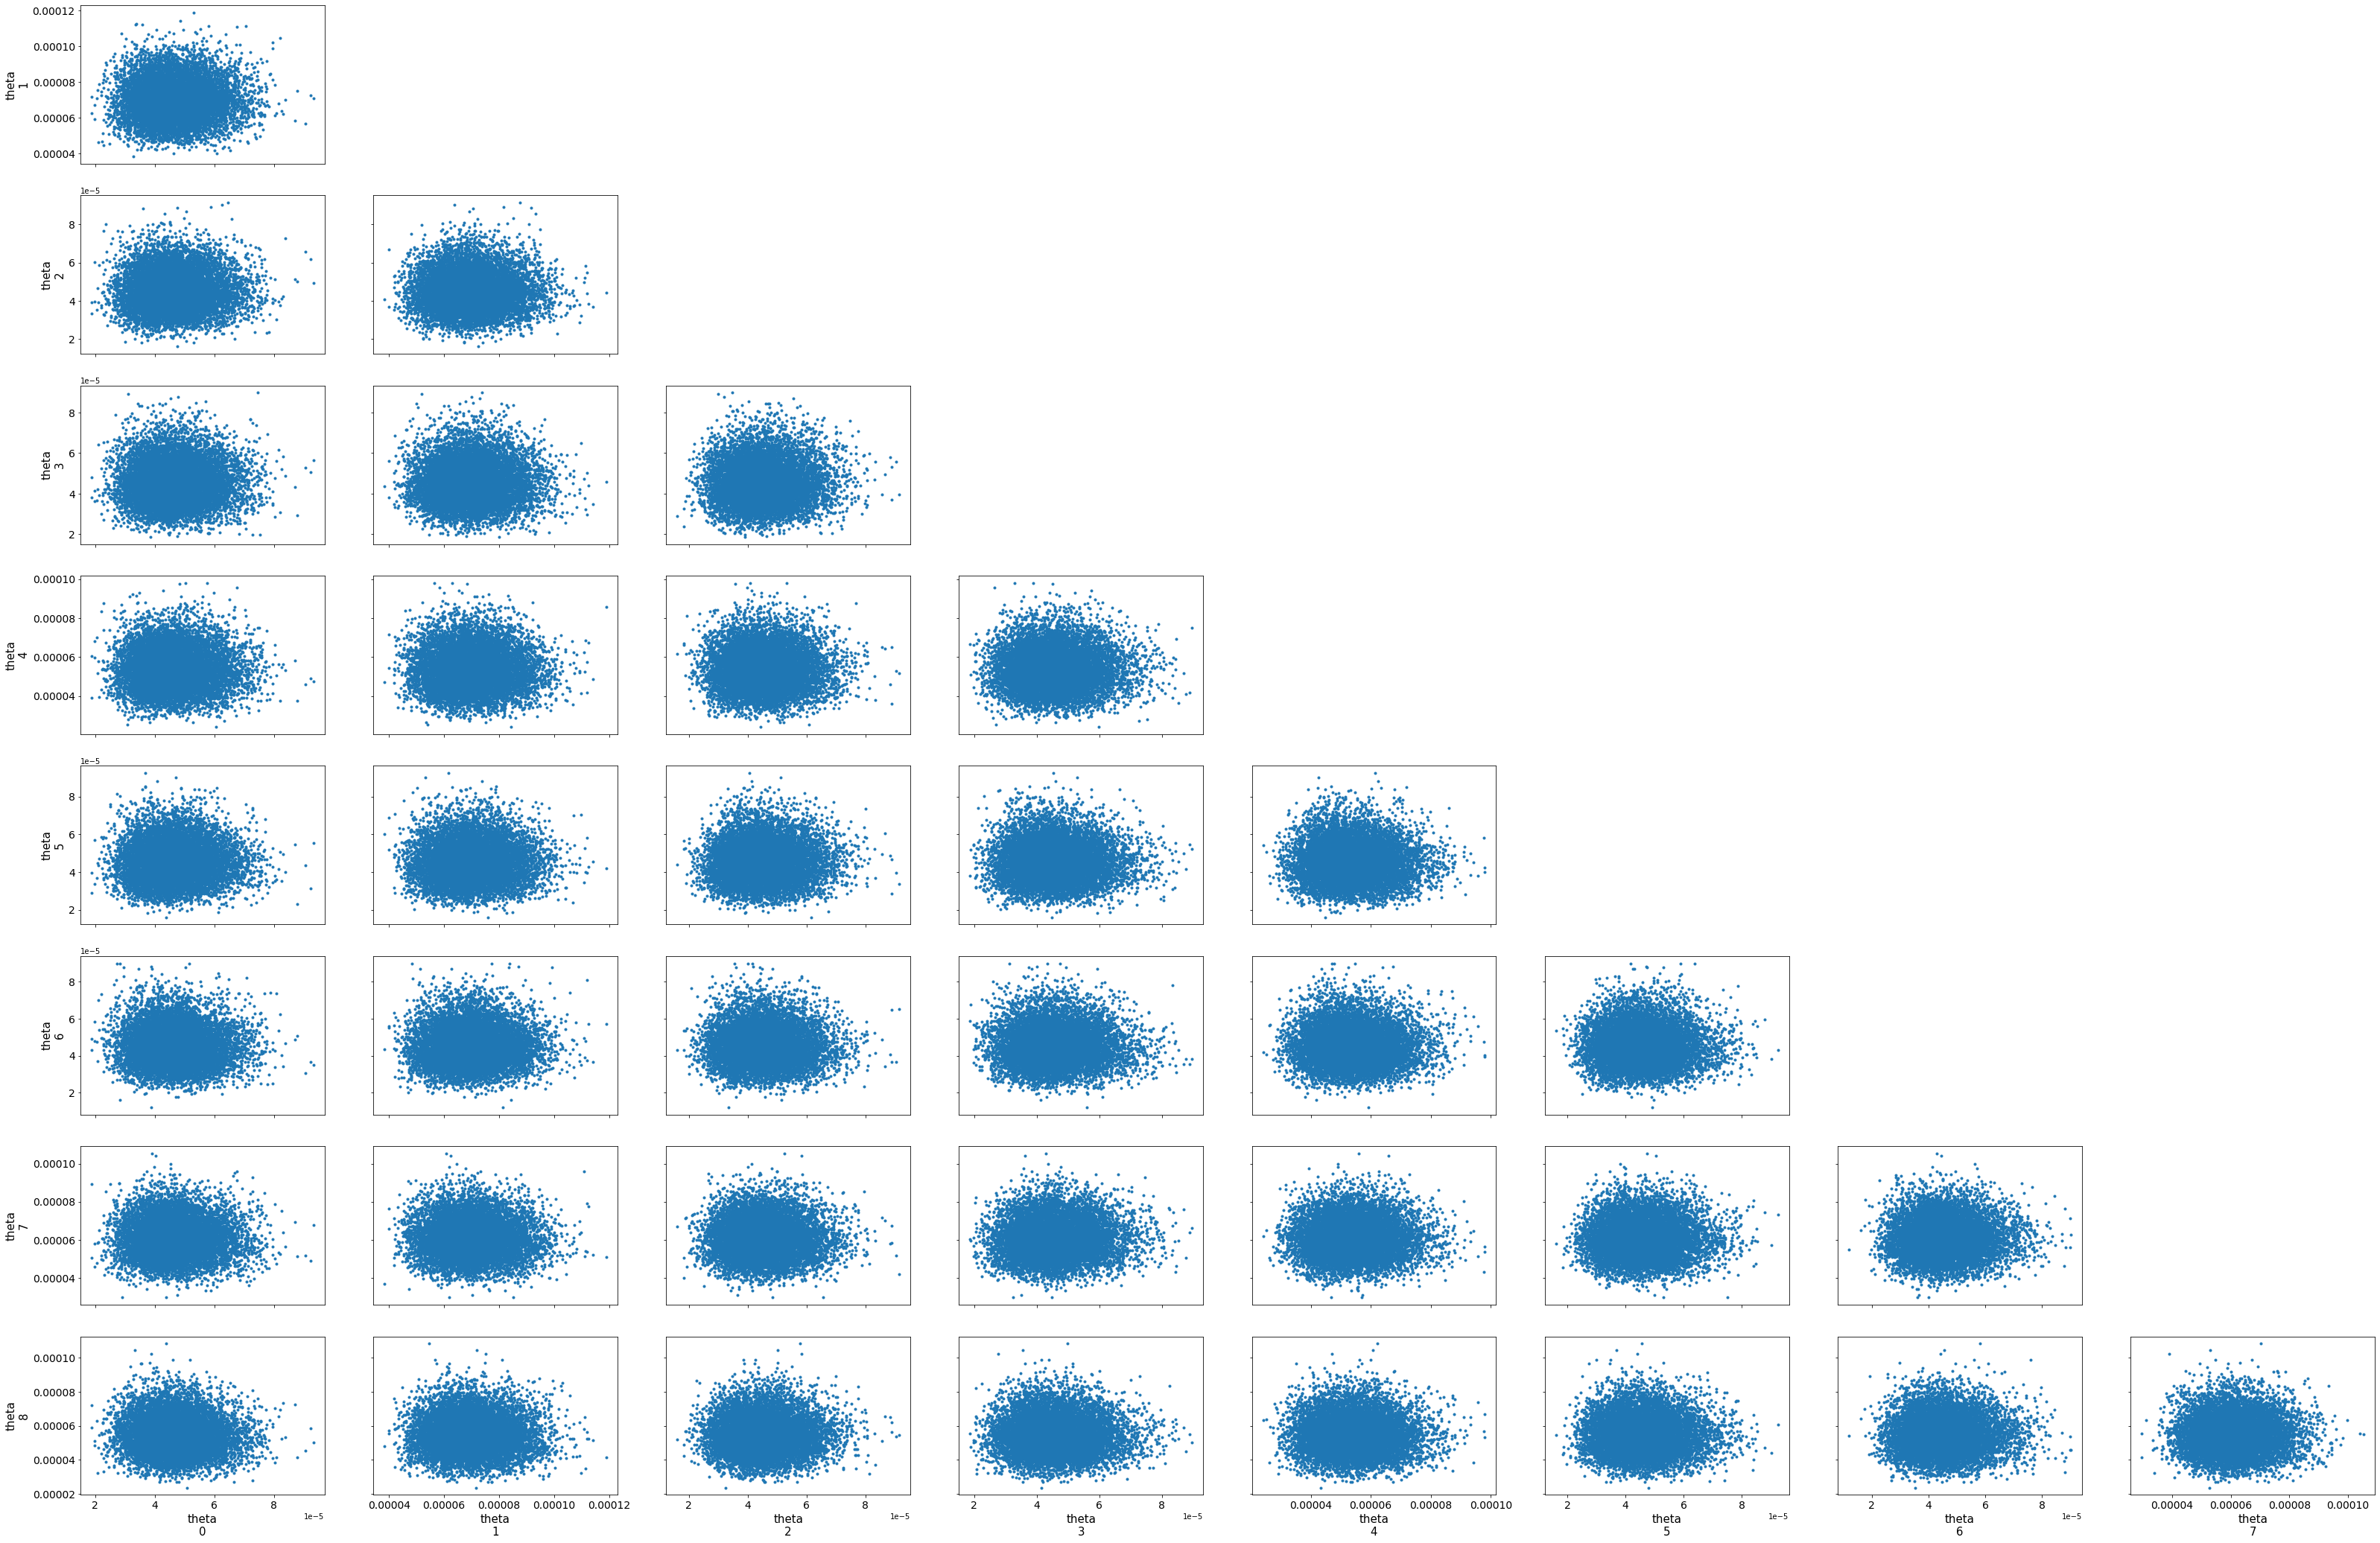

In [17]:
az.plot_pair(pystan_data,divergences=True,var_names=['theta'])

In [18]:
ϵ = 10e-3
def model(population, deathcount):
    α = pyro.param('α', torch.tensor(20.))
    β = pyro.param('β', torch.tensor(430000.))
    p1= pyro.param('p1', torch.ones(data.shape[0]), constraint=constraints.positive)
    p2 = pyro.param('p2', torch.ones(data.shape[0]), constraint=constraints.positive)
    with pyro.plate('data', data.shape[0], subsample_size=32) as idx:
        n_j = population[idx]
        y_j = deathcount[idx]
        # TODO how to incorporate v and w based functoins here
        α_j = α + p1[idx]*y_j
        β_j = β + p2[idx]*n_j
        θ_j = pyro.sample("θ", Gamma(α_j, β_j))
        λ_j = 10*n_j*θ_j + ϵ
        pyro.sample('obs', Poisson(λ_j), obs=y_j)

In [19]:
const = torch.tensor(10.)
pyro.clear_param_store()
def guide(population, deathcount):
    ###
    α = pyro.param('α', torch.tensor(20.))
    β = pyro.param('β', torch.tensor(430000.))
    p1 = pyro.param('p1', torch.ones(data.shape[0]), constraint=constraints.positive)
    p2 = pyro.param('p2', torch.ones(data.shape[0]), constraint=constraints.positive)
    with pyro.plate('data', data.shape[0], subsample_size=32) as idx:
        n_j = population[idx]
        y_j = deathcount[idx]
        α_j = α + p1[idx]*y_j
        β_j = β + p2[idx]*n_j
        θ_j = pyro.sample("θ", Gamma(α_j, β_j))
        

In [20]:
svi = SVI(model, guide, Adam({'lr': 0.025}), JitTrace_ELBO(3))
pbar = tqdm(range(1000))
for i in pbar:
    loss = svi.step(population, deathcount)
    pbar.set_description(f"Loss: {loss}")

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tenso

In [21]:
# TODO: Print parameter values and check whether they correspond to the expected ones
# model what we know

In [22]:
for key, val in pyro.get_param_store().items():
    print("{} = {}".format(key, val))

α = 9.022184371948242
β = 430004.4375
p1 = tensor([0.2278, 0.3331, 0.1970,  ..., 0.2095, 0.2252, 0.2123],
       grad_fn=<AddBackward0>)
p2 = tensor([17.6664,  5.0161, 39.8025,  ..., 27.1462, 27.4096, 32.7330],
       grad_fn=<AddBackward0>)


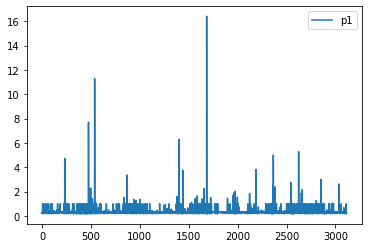

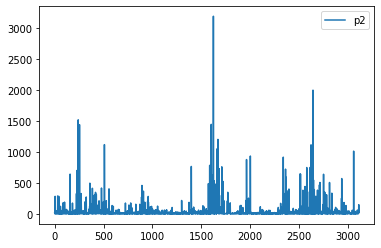

In [23]:
p1 = pyro.get_param_store()["p1"].cpu().detach().numpy()
p2 = pyro.get_param_store()["p2"].cpu().detach().numpy()

plt.plot(p1, label="p1")
plt.legend()
plt.show()

plt.plot(p2, label="p2")
plt.legend()
plt.show()